In [2]:
import pickle
#from utils import * 
import pandas as pd
import numpy as np
import json
import nltk
#nltk.download()

#import seaborn as sns
#import matplotlib.pyplot as plt

In [4]:
def json_df(datapass):
    '''
    Load the json file and parse the file to pandas dataframe format
    
    Input:
        datapass(str) : directory to the json file
    Output:
        df(dataframe) : pandas dataframe object
    '''
    
    data = [] 
    with open(datapass, 'r', encoding='utf-8') as data_file: 
        for f in data_file:
            data.append(json.loads(f))
    df = pd.DataFrame(data)
    return df

#business and review json files --> dataframes

DATAPASS1 = 'C:\\Users\\cdchang\\Downloads\\yelp_dataset\\dataset\\business.json'
DATAPASS2 = 'C:\\Users\\cdchang\\Downloads\\yelp_dataset\\dataset\\review.json'

#business = json_df(DATAPASS1)
reviews = json_df(DATAPASS2)

In [6]:
def display_topics(model, feature_names, n_top_words):
    '''
    display topic with n_top_words in a decsending order of weight
    
    Input:
        model : directory for vectorizer
        feature_names : list of vocabulary 
        n_top_words(int) : number of words to display for each topic

    '''
    for topic_index, topic in enumerate(model.components_):
        print("Topic %d:" % topic_index)
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words:-1]]))

def load_topic_model(vectorizer_file_name, topic_model_file_name):
    with open(vectorizer_file_name, "rb") as f:
        vectorizer = pickle.load(f)
    with open(topic_model_file_name, "rb") as f:
        topic_model = pickle.load(f)
    return vectorizer, topic_model

#pizza

path1 = 'C:\\Users\\cdchang\\Desktop\\yelp-topic-model\\model\\pizza_tfidf_vectorizer.pkl'
path2 = 'C:\\Users\\cdchang\\Desktop\\yelp-topic-model\\model\\pizza_nmf.pkl'
path3 = 'C:\\Users\\cdchang\\Desktop\\yelp-topic-model\\model\\pizza_count_vectorizer.pkl'
path4 = 'C:\\Users\\cdchang\\Desktop\\yelp-topic-model\\model\\pizza_lda.pkl'
vec, tm = load_topic_model(path1, path2)
vec2, tm2 = load_topic_model(path3, path4)

C:\Users\cdchang\Anaconda3\lib\site-packages\sklearn\base.py:312: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.18.1 when using version 0.19.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\cdchang\Anaconda3\lib\site-packages\sklearn\base.py:312: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.18.1 when using version 0.19.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\cdchang\Anaconda3\lib\site-packages\sklearn\base.py:312: UserWarning: Trying to unpickle estimator NMF from version 0.18.1 when using version 0.19.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\cdchang\Anaconda3\lib\site-packages\sklearn\base.py:312: UserWarning: Trying to unpickle estimator CountVectorizer from version 0.18.1 when using version 0.19.0. This might lead to breaking code or invalid results. Use 

In [7]:
tm.components_

array([[  5.35318219e-02,   0.00000000e+00,   4.09802948e-02, ...,
          7.96897006e-02,   3.98538679e-02,   0.00000000e+00],
       [  7.86209423e-02,   1.88202333e-01,   3.27705625e-02, ...,
          2.97546372e-02,   9.73259392e-02,   0.00000000e+00],
       [  3.54345514e-01,   2.62719244e+00,   1.12437870e-01, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       ..., 
       [  4.13455229e-02,   0.00000000e+00,   4.27813136e-04, ...,
          0.00000000e+00,   6.59642074e-02,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          3.22001617e-02,   1.51870707e-01,   0.00000000e+00],
       [  1.37329447e-02,   0.00000000e+00,   7.26685010e-02, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00]])

In [8]:
#k index embedding methods

def get_k_index(sentence, vec, tm):
    '''
    Given a sentence (not the entire review), generate a distribution of topic 
    by adding the weight of topic per words.
    I initialy tried with the product of topic weights but ended up getting 0s.
    
    Also produce the probability vector by scaling the vector so that the sum will be 1.
    
    Input:
        sentence(str) : a sentence to be studied
        vec : vectorizer object 
        tm : topic model object 
    Output:
        k_index (list) : the vector of length k (k = number of topic). 
        prob (list) : k_index but scaled so that the sum of inputs becomes 1 
    '''
    analyzer = vec.build_analyzer()
    topic_words = vec.get_feature_names()
    tm_mat = tm.components_
    k_index = np.array([0.]*tm_mat.shape[0])
    for word in analyzer(sentence):
        if word in topic_words:
            k_index += tm_mat[:, topic_words.index(word)]
    if sum(k_index) == 0:
        prob = np.array([0.]*tm_mat.shape[0])
    else:
        prob = k_index/(sum(k_index))
    return k_index, prob


def get_avg_k_index_for_doc(doc, vec, tm):
    sent_text = nltk.sent_tokenize(doc)
    if (int(len(sent_text)) == 0):
        return []
    else:
        tm_mat = tm.components_
        k_index = np.array([0.]*tm_mat.shape[0])
        for s in sent_text:
            k, p = get_k_index(s, vec, tm)
            k_index += p
        return k_index/int(len(sent_text))

#use this 
def business_id_retrieval(cat, business):
    '''
    Input:
        cat(str) : category
        business(dataframe) : the business data
    Output:
        id_list(set) : business ids of a particular category
    '''
    id_list = set()
    id_list = []
    idx = 0
    for row in business.values:
        categories = row[3]
        if cat in categories:
            id_list.append(row[2])
            
    return id_list

#business_id_retrieval('Pizza', business)

#get_avg_k_index_for_doc("uYHaNptLzDLoV_JZ_MuzUA",vec, tm)

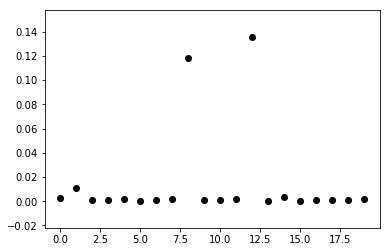

In [113]:
#ultimately: find subset of pizza / chinese restaurants 
#set-up methods
import matplotlib.pyplot as plt
#import plotly.plotly as py
#import plotly.graph_objs as go
#for a single business_id
def examine_reviews(b_id, reviews):
    '''
    concatenate a particular business's review text with the corresponding dates for time series analysis
    
    Input: specific business id, review json file
    Output: concatenated review text & date columns for a particular business id
    '''
    subset = reviews.loc[reviews['business_id'] == b_id]
    date = subset.loc[:, 'date']
    text = subset.loc[:, 'text']
    return pd.concat([date, text], axis=1, join='inner')

#trying with single business id / not tested
def k_index_emb_single(b_id, reviews):
    
    '''
    input: business id, reviews json
    output: weight vectors for each topic, for every review from a particular business, concatenated (sorted by time)
    '''
    
    subset = examine_reviews(b_id, reviews)
    s = subset.sort_values(by="date") #sorting by timestamp
    text_only = s.loc[:, 'text']
    count= 0
    weight_vectors = []
    for t in text_only:
        if (count==0):
            weight_vectors.append(get_avg_k_index_for_doc(t,vec,tm))
        else:
            newcol = get_avg_k_index_for_doc(t,vec,tm)
            weight_vectors = np.vstack([weight_vectors, newcol])
        count = count+1    
    return weight_vectors

def examine_reviews2(cat, business, reviews):
    '''
    concatenate a category's review text with the corresponding dates for time series analysis
    Input: specific category, review json file
    Output: concatenated review text & date columns for a particular category (not business specific) 
    '''
    id_list = business_id_retrieval(cat, business)
    return reviews.loc[reviews['business_id'].isin(id_list)]

def plot_by_topic(b_id, reviews, topic_num): #note, x axis is not made up of timestamps, instead 
    '''
    input:
    output: for a given topic (topic_num), produce a plot where x axis: time of review y axis: k index emb 
    '''
#sort by timestamp
    subset = examine_reviews(b_id, reviews)
    s = subset.sort_values(by="date") #sorting by timestamp

    weight_vectors = k_index_emb_single(b_id, reviews)
    topic_points = list()

#weight_vectors[1][0]
#len(weight_vectors)
    for wv in range(len(weight_vectors)): #for the first topic, hence weight_vectors[wv][0]
        topic_points.append(weight_vectors[wv][topic_num])

    plt.scatter(np.arange(len(weight_vectors)),topic_points,c='black')
    plt.show()

plot_by_topic("HRFJlSAP_EBU_MpPPmpUDQ", reviews, 28)
#8,9 look interesting  - not plotted to scale, axis-wise

Coefficients: 
 [[ 3.68436401]]
Mean squared error: 4.60
Variance score: -0.42


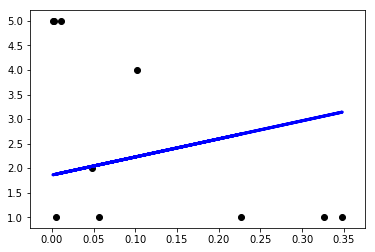

In [147]:
#lin reg classifier code!
import sklearn 
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

#topic (X) vs star rating (y)
def linreg_topics(b_id, reviews):
    print("uhoh")

#subset = examine_reviews("HRFJlSAP_EBU_MpPPmpUDQ", reviews)
subset = reviews.loc[reviews['business_id'] == "HRFJlSAP_EBU_MpPPmpUDQ"]
date = subset.loc[:, 'date']
text = subset.loc[:, 'text']
stars = subset.loc[:,'stars']

pd.concat([date, text, stars], axis=1, join='inner')

s = subset.sort_values(by="date") #sorting by timestamp

weight_vectors = k_index_emb_single("HRFJlSAP_EBU_MpPPmpUDQ", reviews)
topic_points = list()

#for a given topic (in this case, topic index = 0)
for wv in range(len(weight_vectors)): #for the first topic, hence weight_vectors[wv][0]
    topic_points.append(weight_vectors[wv][1])

#convert to np arrays
np_topic_points = np.array(topic_points)
np_stars = np.array(s.loc[:,"stars"])

classif_X_train = np_topic_points[:10]
classif_X_test = np_topic_points[-10:]


s.loc[:,"stars"][:10]
classif_y_train = np_stars[:10]
classif_y_test = np_stars[-10:]

regr = linear_model.LinearRegression()

classif_X_train.reshape(-1,1)
classif_y_train.reshape(-1,1)

classif_X_train.shape= (10,1)
classif_y_train.shape= (10,1)
classif_X_test.shape= (10,1)
classif_y_test.shape= (10,1)

regr.fit(classif_X_train, classif_y_train)
classif_y_pred = regr.predict(classif_X_test)

#the coefficients 
print('Coefficients: \n', regr.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(classif_y_test, classif_y_pred))
# variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(classif_y_test, classif_y_pred))

plt.scatter(classif_X_test, classif_y_test, color='black')
plt.plot(classif_X_test, classif_y_pred, color='blue', linewidth=3)

plt.show()
#business id: "HRFJlSAP_EBU_MpPPmpUDQ"

In [148]:
#sanity check - how well did it predict
print(np.mean(np_stars[-10:])) #actual avg value



2.6


In [ ]:
#SVM classifier code


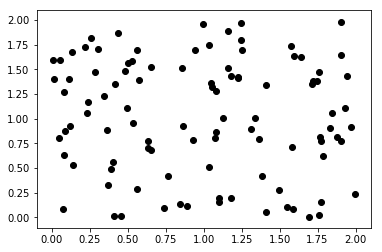

In [78]:
#random things

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms


# THIS WORKS: 
#x, y = np.random.random((2, 100))*2
#fig, ax = plt.subplots()
#ax.scatter(x, y, c='black')
#line = mlines.Line2D([0, 1], [0, 1], color='red')
#transform = ax.transAxes
#line.set_transform(transform)
#ax.add_line(line)
#plt.show()



#TIMESTAMP RANDOM TESTS

#s.loc[:,'date'].date()
#topic_points
#s.dtypes
#plt.plot_date(s.loc[:,'date'],topic_points, fmt = 'o')
#plt.scatter(range(0,20),topic_points)


#data = [go.Scatter( x=subset['date'], y=topic_points)]



#ts = pd.Series(topic_points,s)
#ts
#s.loc[:,'date'][0:4]
#plt.plot(s.loc[:, 'date'], topic_points, 'k-', lw=2)
#for wv in weight_vectors:
#    topic_points.append(weight_vectors[wv][0])
#pd.to_datetime(s)
#plt.plot(s['date'],topic_points, 'k-', lw=2)


#df = df.sort_values('date', ascending=True)

#data = pd.to_numeric(s.loc[:,'date'][0])
#pd.to_numeric(s.loc[:,'date'][1:2])